# Exemple d'estimation d'un seul paramètre: biais d'une pièce de monnaie

Dans ce TP, nous allons explorer l'exemple 1 du livre Sivia & Skilling, présenté dans la section 2.1.
L'exemple présente l'inférence du biais F d'une pièce de monnaie en faveur du côté face.

In [2]:
from typing import Callable, Optional
import numpy as np
import matplotlib.pyplot as plt

# Thomas est daltonien
plt.style.use("tableau-colorblind10")

## Implémentation du modèle

Commençons par implémenter le modèle tel que vu en classe.
Le _prior_ est uniforme, avec comme équation

$$
 P(F) =
   \begin{cases}
     1 & \text{si } 0 \leq F \leq 1,\\
     0 & \text{ailleurs}.\\
   \end{cases}
$$

**Codez le prior pour qu'il puisse appliquer cette condition à un tableau.**

<details>
<summary>Indice</summary>
<br>
Utilisez `np.where()`
</details>

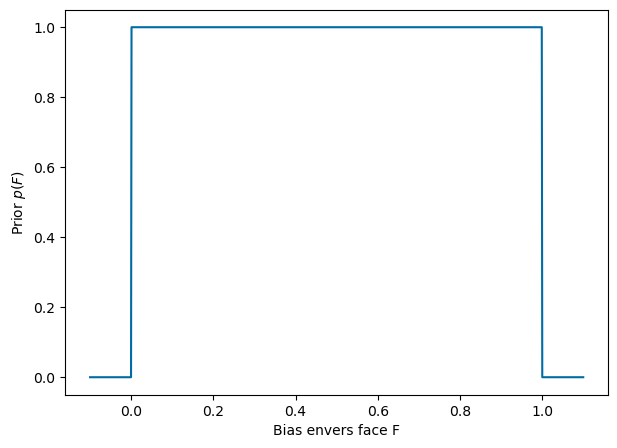

In [3]:
def prior_uniform(f: np.ndarray[float], a: float = 0.0, b: float = 1.0) -> np.ndarray[float]:
    """Prior uniforme entre a et b

    :param f: Valeurs du paramètre f
    :param a: Borne inférieure (min)
    :param b: Borne supérieure (max)
    :return: Valeur du prior 1/(b-a) ou 0
    """
    
    return np.where(np.logical_and(f >= a, f <= b), 1/(b-a), 0)
    
    
    # TODO: Compléter


f_vals = np.linspace(-0.1, 1.1, num=1000)
y_prior = prior_uniform(f_vals)
plt.figure(figsize=(7, 5))
plt.plot(f_vals, y_prior)
plt.xlabel("Bias envers face F")
plt.ylabel("Prior $p(F)$")
plt.show()

La vraisemblance est quant à elle donnée par

$$
P(D|F) \propto F^{R} (1 - F)^{N - R}.
$$

La fonction ci-dessous implémente la vraisemblance.
Remarquez que la vraisemblance n'est pas bornée entre 0 et 1, car elle ne tient pas compte du _prior_.

**Codez la vraisemblance et faites un graphique en fonction de F**

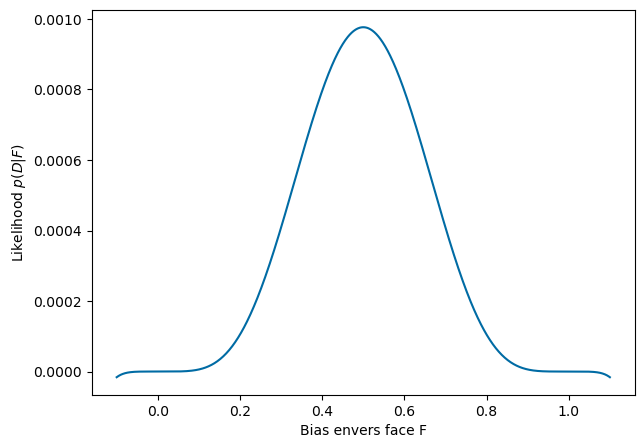

In [4]:
def likelihood(f: np.ndarray[float], r: int, n: int) -> np.ndarray[float]:
    """Vraisemblance binomiale pour le biais F

    :param f: Valeur du paramètre F
    :param r: Nombre de lancers ayant donné "face"
    :param n: Nombre total de lancers
    :return: Valeur de la vraisemblance
    """
    return f**r * (1-f)**(n-r)

r_demo, n_demo = 5, 10
plt.figure(figsize=(7, 5))

y_likelihood = likelihood(f_vals, r_demo, n_demo)
plt.plot(f_vals, y_likelihood)
plt.xlabel("Bias envers face F")
plt.ylabel("Likelihood $p(D|F)$")
plt.show()
# TODO: Afficher un exemple en graphique en fonction de F

Le _posterior_ est donné par le produit du _prior_ et de la vraisemblance.

**Codez le posterior**

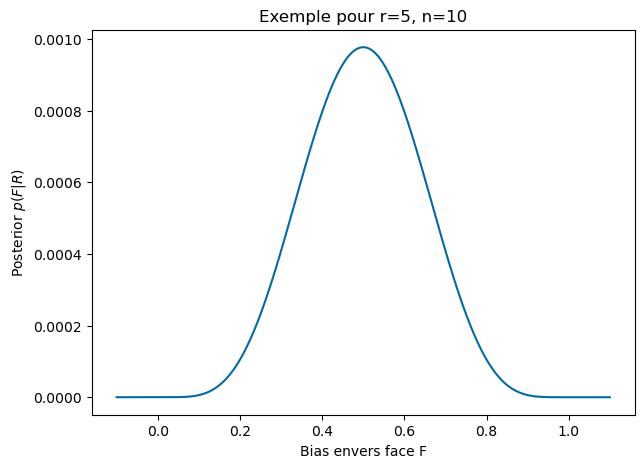

In [5]:
def posterior(f: np.ndarray[float], r: int, n: int, prior_fn: Callable = prior_uniform) -> np.ndarray[float]:
    """Posterior pour F

    :param f: Valeur du paramètre F
    :param r: Nombre de lancers ayant donné "face"
    :param n: Nombre total de lancers
    :return: Valeur de la vraisemblance
    """
    
    return f**r * (1-f)**(n-r) * prior_uniform(f)
    # TODO: Completer
    


r_demo, n_demo = 5,10
plt.figure(figsize=(7, 5))
plt.plot(f_vals, posterior(f_vals, r_demo, n_demo))
plt.xlabel("Bias envers face F")
plt.ylabel("Posterior $p(F|R)$")
plt.title(f"Exemple pour r={r_demo}, n={n_demo}")
plt.show()

Dans chaque cellule ci-dessus, vous pouvez varier `r_demo` et `n_demo` pour voir comment ces valeurs affectent les distributions.

## Simulation des données

Nous allons maintenant simuler des données pour un certain nombre de lancers d'une pièce de monnaie.
Pour ce faire, nous aurons besoin de définir le vrai biais de la pièce `f_true`.
Nous pourrions simuler les lancers directement avec la fonction `binom` de `np.random`.
Par contre, une version itérative de la simulation nous permettra de toujours arriver au même résultat avec un `seed` donné et de progressivement ajouter des lancers dans les sections qui suivent.

**Codez une boucle qui simule les lancers avec une fraction f_true de "face"**

**Retournez le nombre de "face"**

In [6]:
def run_experiment(f_true: float, n: int, seed: Optional[int] = None) -> int:
    """Simulation des lancers d'une pièce de monnaie biaisée

    :param f_true: Coin bias.
    :param n: Nomber of throws.
    :param seed: Seed pour le générateur de nombres aléatoires
    :return: Nombre de lancers ayant donné "face"
    """
    rng = np.random.default_rng(seed=seed)
    
    tot_heads = 0
    
    for i in range(n):
        if f_true >= rng.uniform(0,1): #heads
            tot_heads += 1
    return tot_heads

    # TODO: Completer

3


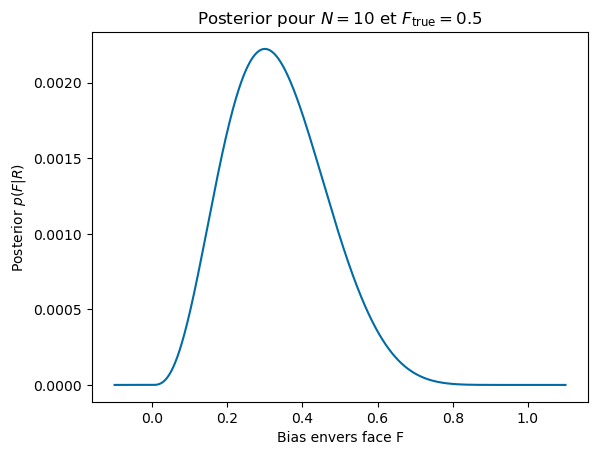

In [7]:
N = 10
f_true = 0.5
r_test = run_experiment(f_true, N, seed=222)
print(r_test)

f_post = posterior(f_vals, r_test, N)
plt.plot(f_vals, f_post)
plt.title(f"Posterior pour $N={N}$ et $F_\\text{{true}}={f_true}$")
plt.xlabel("Bias envers face F")
plt.ylabel("Posterior $p(F|R)$")
plt.show()

## Inférence en fonction du nombre de lancers
On peut effectuer l'inférence bayesienne pour différents nombres de lancers afin de voir comment les résultats convergent.
Pour N = 0, on s'attend à obtenir uniquement le _prior_.
Ensuite, plus on ajoute de lancers (données), plus le _posterior_ devrait se rapprocher de la vraie valeur.
Nous allons reproduire la figure 2.1 du livre avec le code ci-dessous.
Comme la vraisemblance contient une exponentielle, on pourrait avoir des _overflows_ lorsque le nombre de lancers est grand.
Pour pallier à ce problème, nous allons utiliser le log de la vraisemblance, le normaliser, puis reconvertir via une exponentiation.
Notez que la normalisation ne dérange pas dans ce cas-ci, car ce n'est qu'une exporation de paramètres), nous allons donc seulement diviser par le maximum avant d'afficher pour faciliter la visualisation.

**Codez la vraisemblance en utilisant ces équations. Votre fonction doit retourner p_2**

$$
L = \ln p(D|F) = R \ln f + (N - R) \ln (1-f)
$$

$$
c = \mathrm{max}(L)
$$

$$
\mathrm{LSE} = c + \ln{(\sum e^{L - c})}
$$

$$
p_2(D|F) = e^{L - LSE}
$$

In [23]:
def likelihood(f: np.ndarray[float], r: int, n: int) -> np.ndarray:
    """Vraisemblance normalisée via le "log-sum-exp"

    :param f: Valeur du paramètre F
    :param r: Nombre de lancers ayant donné "face"
    :param n: Nombre total de lancers
    :return: Vraisemblance
    """
    
    L = r * np.log(f) + (n-r) * np.log(1-f)
    c = np.max(L)
    
    LSE = c + np.log(np.sum(np.exp(L-c)))
    
    p_2 = np.exp(L-LSE)
    
    return p_2
    
    # TODO: Utilier le "log-sum-exp" pour calculer la vraisemblance.

def posterior(f: np.ndarray[float], r: int, n: int, prior_fn: Callable = prior_uniform) -> np.ndarray[float]:
    return likelihood(f, r, n) * prior_fn(f)

**Complétez les TODO pour simuler les données et calculer le _posterior_**

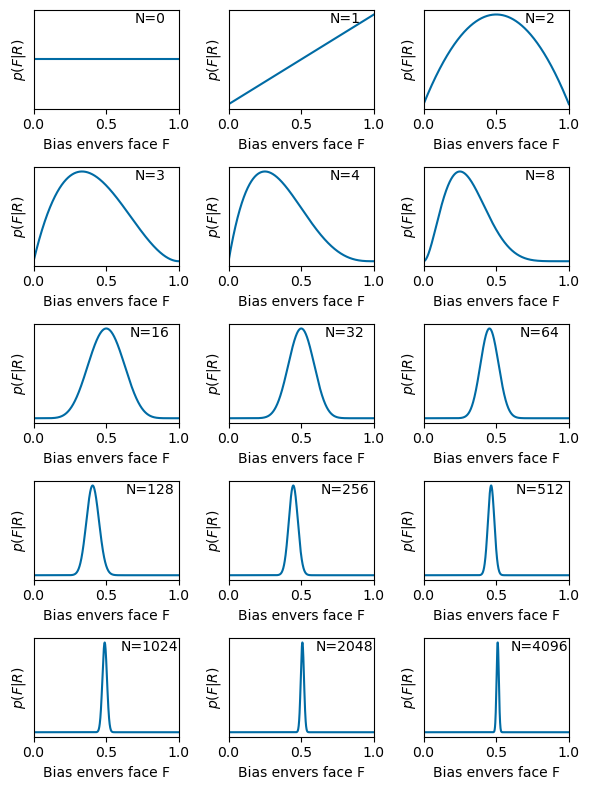

In [36]:
N_values = 2 ** np.arange(13)
N_values = np.sort(np.append(N_values, [0, 3]))
ncols = 3
nrows = int(np.ceil(len(N_values) / ncols))


f_vals = np.linspace(1e-5, 0.9999, num=1000)
f_true = 0.5
seed = 222
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 8))
for i in range(len(N_values)):
    ax = axes.ravel()[i]
    Ni = N_values[i]
    
    r_test = run_experiment(f_true, Ni, seed=seed)
    y_likelihood = likelihood(f_vals, r_test, Ni)
    y_prior = prior_uniform(f_vals)  
    y_posterior = y_prior * y_likelihood
    
    # TODO: Simuler les données (n'oubliez pas le seed)
    # TODO: Calculez le posterior pour ce nombre de lancers
    # TOOD: Utilisez ax.plot() pour afficher le résultat
    
    ax.plot(f_vals, y_posterior)
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel("Bias envers face F")
    ax.set_ylabel("$p(F|R)$")
    ax.text(0.8, 0.87, f"N={Ni}", horizontalalignment="center", transform=ax.transAxes)
plt.tight_layout()
plt.show()

## Test de différents _priors_

Nous allons maintenant reproduire la section 2.1.1. du livre.
Nous utiliserons un _prior_ Gaussien qui assume une pièce normale et un _prior_ "Vegas" qui assume une pièce biaisée.

$$
p_G(F) = \frac{1}{\sqrt{2 \pi}\sigma} e^{(F - \mu)^2 / 2 \sigma^2},
$$

où on utilise $\mu=0.5$ et $\sigma=0.05$.

$$
p_V(F) = e^{- b f} + e^{b (f - 1)},
$$

avec $b = 20$.

**Codez ces deux priors et affichez les avec le prior uniforme. "Normalisez" les priors pour que leur maximum soit égal à 1.**

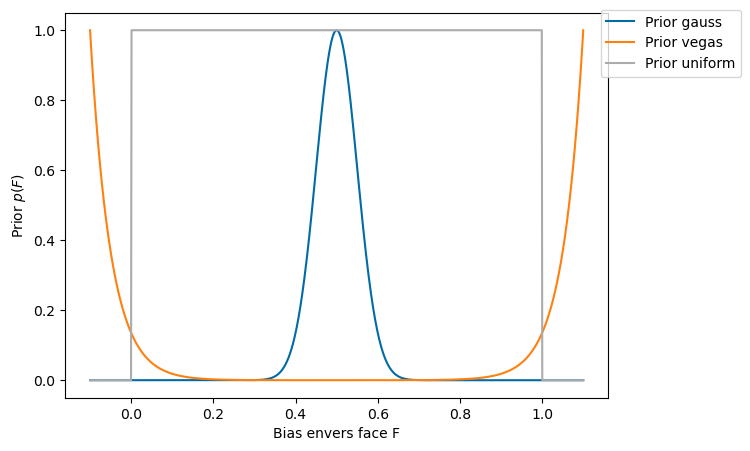

In [41]:
def prior_gauss(f: np.ndarray[float], mu:float=0.5, sd: float=0.05) -> np.ndarray[float]:
    # TODO: Prior gaussien

    Pg = 1/ ((2 * np.pi) ** (1/2) * sd) * np.exp(-(f - mu)**2 / (2 * sd**2))
    return Pg/np.max(Pg)


def prior_vegas(f: np.ndarray[float], b: float=20.0) -> np.ndarray[float]:
    # TODO: Exponentielle

    Pv = np.exp(-1 * b * f) + np.exp(b * (f-1))
    return Pv/np.max(Pv)


# TODO: Afficher les priors
f_vals = np.linspace(-0.1, 1.1, num=1000)
fig = plt.figure(figsize=(7, 5))


plt.plot(f_vals, prior_gauss(f_vals), label='Prior gauss')
plt.plot(f_vals, prior_vegas(f_vals), label='Prior vegas')
plt.plot(f_vals, prior_uniform(f_vals), label='Prior uniform')
plt.xlabel("Bias envers face F")
plt.ylabel("Prior $p(F)$")
fig.legend(bbox_to_anchor=(1.1, 0.9))
plt.show()

**Répétez l'expérience pour différents N comme ci-dessus pour reproduire la figure, mais cette fois avec les posteriors pour chaque prior. Utilisez l'argument `prior_fn`**

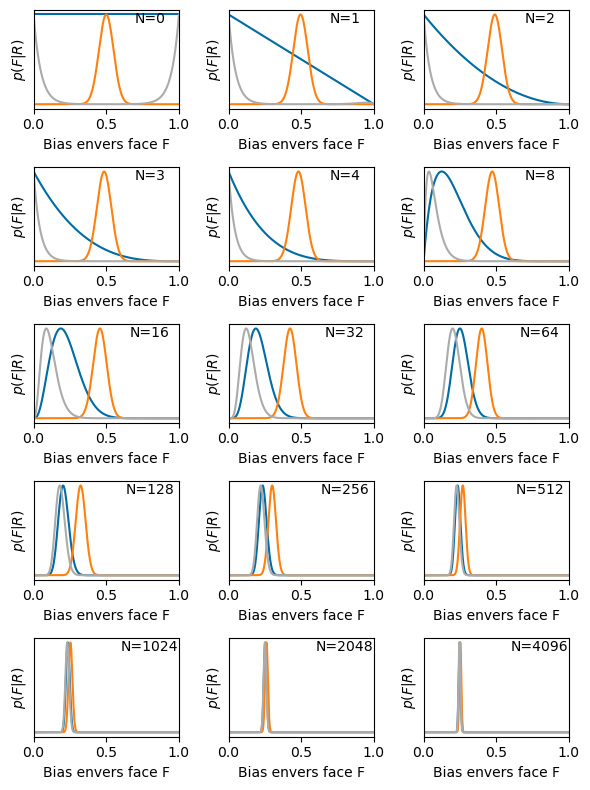

In [43]:
# TODO: Répéter
N_values = 2 ** np.arange(13)
N_values = np.sort(np.append(N_values, [0, 3]))
ncols = 3
nrows = int(np.ceil(len(N_values) / ncols))


f_vals = np.linspace(1e-5, 0.9999, num=1000)
f_true = 0.25
seed = 222
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 8))

prior_strings = ['Uniform', 'Gauss', 'Vegas']

for i in range(len(N_values)):
    ax = axes.ravel()[i]
    Ni = N_values[i]
    
    r_test = run_experiment(f_true, Ni, seed=seed)
    
    # TODO: Simuler les données (n'oubliez pas le seed)
    # TODO: Calculez le posterior pour ce nombre de lancers
    # TOOD: Utilisez ax.plot() pour afficher le résultat
    
    ax.plot(f_vals, posterior(f_vals, r_test, Ni, prior_fn=prior_uniform)/np.max(posterior(f_vals, r_test, Ni, prior_fn=prior_uniform)))
    ax.plot(f_vals, posterior(f_vals, r_test, Ni, prior_fn=prior_gauss)/np.max(posterior(f_vals, r_test, Ni, prior_fn=prior_gauss)))
    ax.plot(f_vals, posterior(f_vals, r_test, Ni, prior_fn=prior_vegas)/np.max(posterior(f_vals, r_test, Ni, prior_fn=prior_vegas)))
    
    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_xlabel("Bias envers face F")
    ax.set_ylabel("$p(F|R)$")
    ax.text(0.8, 0.87, f"N={Ni}", horizontalalignment="center", transform=ax.transAxes)
plt.tight_layout()
plt.show()


On peut voir que le _prior_ "Vegas" converge assez rapidement à la même conclusion que le _prior_ uniforme.
Ceci n'est pas trop surprenant: une fois les extrémités éliminées, le _prior_ "Vegas" est plutôt plat.
Pour ce qui est du prior Gaussien, on peut voir qu'il prend beaucoup plus de temps à converger vers la bonne solution en raison de la forte préférence initiale pour une pièce non biaisée.

## Exemple réaliste: une seule expérience

_La section suivante est une bonne préparation pour le devoir. Une bonne partie de l'analyse ci-dessous pourra y être réutilisée. Vous pouvez donc utiliser cet exercice pour vous préparer au devoir._


Nous pouvons maintenant faire un exemple réaliste avec une seule expérience et faire une analyse complète.

1. Simuler l'expérience avec `f_true = 0.35` et `N=20`.
2. Calculer la distribution _posterior_.
3. Calculer l'évidence.
4. Normaliser la distribution _posterior_.
5. Calculer la moyenne, la médiane et la valeur maximale du posterior
6. Affichez ces valeurs sur le graphqiue
7. Calculez la valeur de l'écart type et affichez un intervalle.
8. Calculez un intervalle de confiance numérique à 68%.

1.0000000000000002
0.2272727272727177


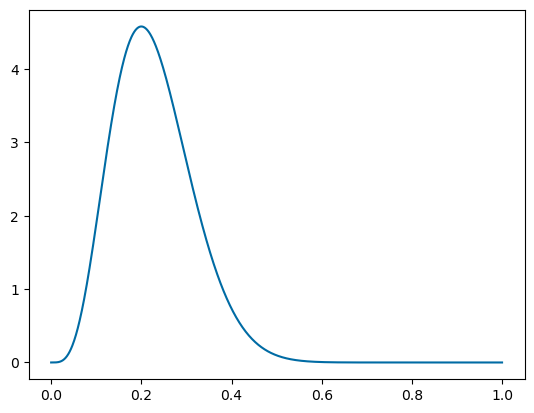

In [77]:
N = 20
f_vals = np.linspace(1e-5, 0.9999, num=1000)
f_true = 0.35
seed = 222
r_test = run_experiment(f_true, N, seed=seed)

y_posterior = posterior(f_vals, r_test, N)/np.trapz(posterior(f_vals, r_test, N), f_vals)
#y_post is normalized

moyenne = np.trapz(y_posterior * f_vals, f_vals)
print(moyenne)

plt.plot(f_vals, y_posterior)
plt.show()

